In [240]:
from __future__ import division, absolute_import, print_function
%load_ext autoreload
%autoreload 2

import os 
print(os.getcwd()) 
    
#import hepran
#import hepran.bzipscore as bz
#import hepran.bcipa as bc
#import hepran.utils as u
#import hepran.registers as r
#import hepran.agadir as ag

import pandas as pd
import numpy as np
import seaborn as sns
    
%matplotlib inline

import matplotlib as mpl
import matplotlib.pylab as plt

import sklearn as sk


CCO = os.environ.get("CCO",r"C:\Projekti_KI\ortoCC\CoiledCoilOrtho")


def getRMSE(x, y, df):
    return np.sqrt(((df[x]-df[y])**2).mean())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
d:\data\ortoCC\fine_tune_scoring_function


In [241]:
import bokeh
import bokeh.plotting as bp
from bokeh.models import HoverTool
from IPython.core.display import display, HTML
import hepran
bp.output_notebook()

Loading BokehJS ...

In [242]:
df = pd.read_excel('data/round0_fiting.xlsx',index_col=[0,1])

In [243]:
df.columns

Index([u'seq1', u'seq2', u'Tm', u'on_target', u'avg_HP1', u'avg_HP2',
       u'avg_HP_12', u'HP1', u'HP2', u'HP_12', u'nterm_c_NN', u'nterm_c_IN',
       u'nterm_c_II', u'cterm_c_NN', u'cterm_c_IN', u'cterm_c_II', u'c_NN',
       u'c_IN', u'c_II', u'es_EE', u'es_EK', u'es_KK', u'interface_charge1',
       u'interface_charge2', u'interface_repulsion', u'cv_NN', u'cv_II',
       u'cv_NI', u'cv_IN', u'esv_KK', u'esv_EE', u'esv_EK', u'esv_KE',
       u'cvt_NNI', u'cvt_IIN', u'cvt_NNN', u'cvt_NIN', u'cvt_INN', u'cvt_III',
       u'cvt_INI', u'cvt_NII', u'esvt_EKK', u'esvt_EEK', u'esvt_EEE',
       u'esvt_EKE', u'esvt_KEE', u'esvt_KKK', u'esvt_KKE', u'esvt_KEK'],
      dtype='object')

In [244]:
basic = 'c_NN c_IN c_II es_EE es_EK es_KK'.split()
nterm_core = 'nterm_c_NN nterm_c_IN nterm_c_II'.split()
cterm_core = 'cterm_c_NN cterm_c_IN cterm_c_II'.split()
core_ends = nterm_core + cterm_core 

core_vertical = 'cv_NN cv_II cv_NI cv_IN'.split()
es_vertical = 'esv_KK esv_EE esv_EK esv_KE'.split()

core_t_vertical = 'cvt_INI cvt_IIN cvt_NII cvt_NNI cvt_NNN cvt_NIN cvt_INN cvt_III'.split()
es_t_vertical = 'esvt_EKK esvt_EEK esvt_EEE esvt_EKE esvt_KEE esvt_KKK esvt_KKE esvt_KEK'.split()
interface_rep = ['interface_repulsion']

fit_fields_dic = {
    "basic": basic,
    "basic_ends": basic + core_ends,
    "basic_rep": basic + interface_rep,
    "basic_ends_rep": basic + core_ends+interface_rep,
}


In [254]:
def set_weights(name):
    
    df['weights'] = 1
    if name == "W10LH":
        df['weights'] = 1
        df.loc[df.Tm < 10, 'weights'] = 10
        df.loc[df.Tm > 55, 'weights'] = 10
        df.loc[df.on_target, 'weights'] = 10
    if name == "W10":
        df.loc[df.on_target, 'weights'] = 10
    if name == "W10L":
        df['weights'] = 1
        df.loc[df.Tm < 15, 'weights'] = 10
        df.loc[df.on_target, 'weights'] = 10
    

172
R2:  0.788884015525
RMSE all:  13.7631137201
RMSE >25:  14.1855563106
RMSE on_target:  6.92486782034


,feature,coef
0,c_NN,3.359381
1,c_IN,-1.679690
2,c_II,3.359381
3,es_EE,-3.276771
4,es_EK,3.053762
5,es_KK,-1.180565
6,interface_repulsion,-0.356290
7,cv_NN,-1.884486
8,cv_II,2.307046
9,cv_NI,2.638729


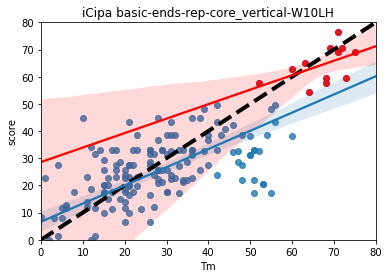

In [284]:
import sklearn
from sklearn import linear_model
from sklearn.externals import joblib

#fit_type = "basic-ends-rep"
#fit_fields = basic + interface_rep 



fit_type = "basic-ends-rep-core_vertical"
fit_fields = basic + interface_rep + core_vertical 


fit_type = "basic-ends-rep-nter_core-vertical_all"
fit_fields = basic + interface_rep + nterm_core + core_t_vertical + es_t_vertical

fit_type = "basic-ends-rep-core_t_vertical"
fit_fields = basic + interface_rep +  core_t_vertical

#BEST
fit_type = "basic-ends-rep-nter_core-core_vertical"
fit_fields = basic + interface_rep + nterm_core + core_vertical


fit_type = "basic-ends-rep-core_vertical"
fit_fields = basic + interface_rep + core_vertical


weight_string="W10LH"

set_weights(weight_string)
if weight_string:
    fit_type += "-" + weight_string

Q = df.query('(Tm > -15)')
print(len(Q))
Q.head()

Y=Q['Tm']
X=Q[fit_fields] 
W=Q.weights
lm = linear_model.Ridge(normalize=True, alpha=0.03)
lm.fit(X, Y, W)
#lm.coef_ = [70, 5, -5, 5, -5, 5, -5]
#lm.intercept_=20
#lm.fit(X, Y)


df['score'] = lm.predict(df[fit_fields])


joblib.dump(lm, 'models/{fit_type}.model'.format(**locals())) 
df.to_excel('data/mason_both.iCipa_{fit_type}.score.xlsx'.format(**locals()))


plt.plot([0,80], [0,80], 'k--', lw=4)
plt.title('iCipa '+fit_type)
plt.ylim([0,80])
plt.xlim([0,80])
#print(fit_fields)
print("R2: ",lm.score(X,Y, W))
print("RMSE all: ",getRMSE('Tm', 'score', df))
print("RMSE >25: ",getRMSE('Tm', 'score', df.query('Tm > 25')))
print("RMSE on_target: ",getRMSE('Tm', 'score', df.query('on_target')))
sns.regplot(x='Tm', y='score', fit_reg=True, data=df)
sns.regplot(x='Tm', y='score', fit_reg=True, data=df.query('on_target'), color='red')

#ax = plt.gca()
#for n,q in Q.query('on_target').iterrows():
#    #print(q.name,q.Tm, q.Tm_pred)
#    ax.annotate(q.name, (q.Tm, q.Tm_pred))
pd.DataFrame(zip(X.columns, lm.coef_), columns="feature coef".split())

In [285]:
from Interactive_set_plot import *
def get_formated_seq(row):
    row['seq1_disp'] = hepran.registers.html_format_amino_acids(row.seq1,'f')
    row['seq2_disp'] = hepran.registers.html_format_amino_acids(row.seq2,'f')
    return row

df = df.apply(get_formated_seq, axis=1)

df['IDs']=df.index


bp.show(draw_scatter_interactive('Tm','score',df, y_range=(0,80),                                
                                 title=fit_type, save_to_file=False))

(0, 80)
